# Init

In [1]:
# conda env: yttest2

# %config InlineBackend.figure_format = 'retina'
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information numpy, scipy, matplotlib, yt, pandas, torch, pyg, h5py, seaborn, sklearn, umap, astropy, astroquery, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2023-09-25 22:52:16 (GMT+0900) 


/home/dhhyun/anaconda3/envs/yttest2/lib/python3.9/_collections_abc.py:769: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


0 Python     3.9.7 64bit [GCC 7.5.0]
1 IPython    8.8.0
2 OS         Linux 3.10.0 862.3.3.el7.x86_64 x86_64 with glibc2.17
3 numpy      1.23.5
4 scipy      1.10.0
5 matplotlib 3.3.4
6 yt         3.6.1
7 pandas     1.4.4
8 torch      1.12.1
9 pyg        The 'pyg' distribution was not found and is required by the application
10 h5py       3.8.0
11 seaborn    0.12.2
12 sklearn    1.0.2
13 umap       0.5.3
14 astropy    The 'astropy' distribution was not found and is required by the application
15 astroquery The 'astroquery' distribution was not found and is required by the application
16 version_information 1.0.4


making a dataset?

In [2]:
import os
from time import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
import random

In [3]:
workdir = '/data1/dhhyun/GraphSMOTE/GraphSmote'

In [4]:
pwd

'/home/dhhyun'

In [5]:
cd workdir

[Errno 2] No such file or directory: 'workdir'
/home/dhhyun


In [7]:
cd '/data1/dhhyun/GraphSMOTE/GraphSmote'

/data1/dhhyun/GraphSMOTE/GraphSmote


In [8]:
pwd

'/data1/dhhyun/GraphSMOTE/GraphSmote'

In [18]:
import sys
sys.path.append('/data1/dhhyun/GraphSMOTE/GraphSmote')
from data_load import * # normalize

In [89]:
import argparse
import scipy.sparse as sp
import numpy as np
import torch
import ipdb
from scipy.io import loadmat
import utils
from collections import defaultdict


def load_data(path="data/cora/", dataset="cora"):#modified from code: pygcn
    """Load citation network dataset (cora only for now)"""
    #input: idx_features_labels, adj
    #idx,labels are not required to be processed in advance
    #adj: save in the form of edges. idx1 idx2
    #output: adj, features, labels are all torch.tensor, in the dense form
    #-------------------------------------------------------

    print('Loading {} dataset...'.format(dataset))

    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset),
                                        dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    labels = idx_features_labels[:, -1]
    set_labels = set(labels)
    classes_dict = {c: np.arange(len(set_labels))[i] for i, c in enumerate(set_labels)}
    classes_dict = {'Neural_Networks': 0, 'Reinforcement_Learning': 1, 'Probabilistic_Methods': 2, 'Case_Based': 3, 'Theory': 4, 'Rule_Learning': 5, 'Genetic_Algorithms': 6}

    #ipdb.set_trace()
    labels = np.array(list(map(classes_dict.get, labels)))
    
    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset),
                                    dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    features = normalize(features)

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(labels)

    utils.print_edges_num(adj.todense(), labels)

    adj = sparse_mx_to_torch_sparse_tensor(adj)
    #adj = torch.FloatTensor(np.array(adj.todense()))

    return adj, features, labels

In [90]:
adj, features, labels = load_data()

Loading cora dataset...
edges between class 0 and class 0: 2350.000000
edges between class 0 and class 1: 67.000000
edges between class 0 and class 2: 137.000000
edges between class 0 and class 3: 54.000000
edges between class 0 and class 4: 161.000000
edges between class 0 and class 5: 16.000000
edges between class 0 and class 6: 53.000000
edges between class 1 and class 0: 67.000000
edges between class 1 and class 1: 818.000000
edges between class 1 and class 2: 20.000000
edges between class 1 and class 3: 28.000000
edges between class 1 and class 4: 32.000000
edges between class 1 and class 5: 2.000000
edges between class 1 and class 6: 62.000000
edges between class 2 and class 0: 137.000000
edges between class 2 and class 1: 20.000000
edges between class 2 and class 2: 1320.000000
edges between class 2 and class 3: 19.000000
edges between class 2 and class 4: 88.000000
edges between class 2 and class 5: 6.000000
edges between class 2 and class 6: 2.000000
edges between class 3 and 

In [64]:
adj, features, labels

(<2708x2708 sparse matrix of type '<class 'numpy.float32'>'
 	with 5429 stored elements in COOrdinate format>,
 <2708x1433 sparse matrix of type '<class 'numpy.float32'>'
 	with 3880564 stored elements in Compressed Sparse Row format>,
 array([0, 5, 1, ..., 6, 3, 0]))

In [65]:
adj.shape, features.shape, labels.shape

((2708, 2708), (2708, 1433), (2708,))

(array([818., 217.,   0., 426.,   0., 298., 351.,   0., 180., 418.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

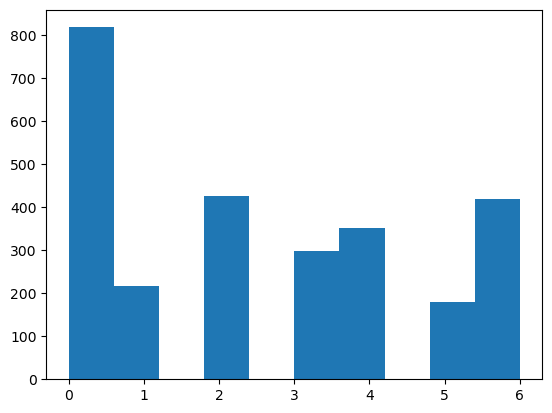

In [66]:
plt.hist(labels)

In [21]:
adj

tensor(indices=tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
                       [   8,   14,  258,  ...,  774, 1389, 2344]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(2708, 2708), nnz=10556, layout=torch.sparse_coo)

In [38]:
indices = adj.coalesce().indices()
indices

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [   8,   14,  258,  ...,  774, 1389, 2344]])

In [39]:
indices.shape

torch.Size([2, 10556])

In [35]:
adj.coalesce().values()

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [37]:
adj.coalesce().size()

torch.Size([2708, 2708])

In [91]:
features

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [41]:
features.shape

torch.Size([2708, 1433])

In [45]:
features[0,:].numpy()

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

(array([1413.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          20.]),
 array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
        0.045, 0.05 ], dtype=float32),
 <BarContainer object of 10 artists>)

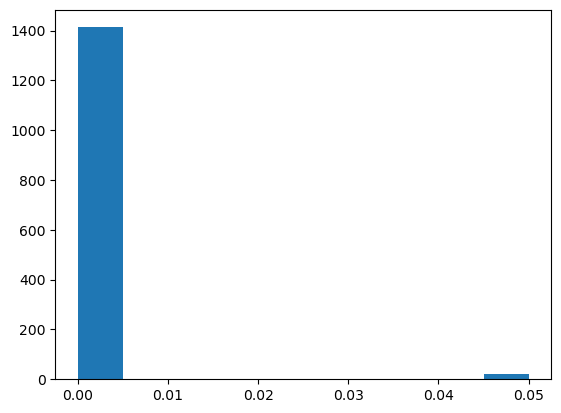

In [93]:
plt.hist(features[0,:].numpy())

In [48]:
pwd

'/data1/dhhyun/GraphSMOTE/GraphSmote'

In [49]:
idx_features_labels = np.genfromtxt("data/cora/cora.content", dtype=np.dtype(str))

In [50]:
idx_features_labels

array([['31336', '0', '0', ..., '0', '0', 'Neural_Networks'],
       ['1061127', '0', '0', ..., '0', '0', 'Rule_Learning'],
       ['1106406', '0', '0', ..., '0', '0', 'Reinforcement_Learning'],
       ...,
       ['1128978', '0', '0', ..., '0', '0', 'Genetic_Algorithms'],
       ['117328', '0', '0', ..., '0', '0', 'Case_Based'],
       ['24043', '0', '0', ..., '0', '0', 'Neural_Networks']],
      dtype='<U22')

In [51]:
np.shape(idx_features_labels)

(2708, 1435)

In [54]:
features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
labels = idx_features_labels[:, -1]
set_labels = set(labels)
classes_dict = {c: np.arange(len(set_labels))[i] for i, c in enumerate(set_labels)}
classes_dict = {'Neural_Networks': 0, 'Reinforcement_Learning': 1, 'Probabilistic_Methods': 2, 'Case_Based': 3, 'Theory': 4, 'Rule_Learning': 5, 'Genetic_Algorithms': 6}

#ipdb.set_trace()
labels = np.array(list(map(classes_dict.get, labels)))

# build graph
idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
idx_map = {j: i for i, j in enumerate(idx)}
edges_unordered = np.genfromtxt("data/cora/cora.cites",
                                dtype=np.int32)
edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                 dtype=np.int32).reshape(edges_unordered.shape)
adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                    shape=(labels.shape[0], labels.shape[0]),
                    dtype=np.float32)

In [57]:
labels

array([0, 5, 1, ..., 6, 3, 0])

In [60]:
set(idx_features_labels[:,-1])

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

In [62]:
classes_dict.get

<function dict.get(key, default=None, /)>

# DM dataset

In [73]:
def load_data(i, f, local=False, spherical=True):
    dataset = []
    if not local: Xlist, ylist, edgelist = [], [], []
    
    for num in np.arange(i,f):
        df_sphere = pd.read_csv(f'/data1/dhhyun/DM100/df_DM{num:02}.csv', index_col=0)
        edge_index = np.genfromtxt(f'/data1/dhhyun/DM100/DM{num:02}_graph_R1kpc.csv', delimiter=',', dtype='int')
        edge_index = torch.tensor(edge_index, dtype=torch.long)
        edge_index = edge_index.t().contiguous()

        if local:
            if spherical:
                X = np.column_stack((df_sphere['r'], df_sphere['theta'], df_sphere['phi'],
                    df_sphere['v_r'], df_sphere['v_theta'], df_sphere['v_phi']))
            else:
                X = np.column_stack((df_sphere['lx'], df_sphere['ly'], df_sphere['lz'],
                    df_sphere['vx'], df_sphere['vy'], df_sphere['vz']))
            y = np.array(df_sphere['flag']) # 1 for bound. #0 < #1
            
            # Normalization
            scaler = MinMaxScaler() # axis=0 default
            scaler.fit(X) 
            X = scaler.transform(X)
            
            # Data Object
            X = torch.tensor(X, dtype=torch.float)
            y = torch.tensor(y, dtype=torch.float) # not int32 #################### originally torch.long for class identification
            data = Data(x=X, edge_index=edge_index, y=y)
                        # train_mask=train_mask, test_mask=test_mask) # below
            dataset.append(data)
            
        elif not local:
            if spherical:
                X = np.column_stack((df_sphere['gr'], df_sphere['gtheta'], df_sphere['gphi'],
                    df_sphere['gv_r'], df_sphere['gv_theta'], df_sphere['gv_phi']))
            else:
                X = np.column_stack((df_sphere['x'], df_sphere['y'], df_sphere['z'],
                    df_sphere['vx'], df_sphere['vy'], df_sphere['vz']))
            y = np.array(df_sphere['flag']) # 1 for bound. #0 < #1
            Xlist.append(X)
            ylist.append(y)
            edgelist.append(edge_index)
            
    # Global Scaling
    if not local: 
        X_train = np.concatenate(Xlist[0::2], axis=0)
        X_test = np.concatenate(Xlist[1::2], axis=0)
        
        # Normalization
        scaler1 = MinMaxScaler() # axis=0 default
        scaler1.fit(X_train) 
        scaler2 = MinMaxScaler()
        scaler2.fit(X_test) 
        
        for index, (X, y, edge_index) in enumerate(zip(Xlist, ylist, edgelist)):
            if index%2==0:
                X = scaler1.transform(X)
            else:
                X = scaler2.transform(X)
                
            # Data Object
            X = torch.tensor(X, dtype=torch.float)
            y = torch.tensor(y, dtype=torch.float) # not int32 ### originally torch.long for class identification
            data = Data(x=X, edge_index=edge_index, y=y)
            dataset.append(data)
            
    return dataset # [0::2], dataset[1::2] # training, test

DM_dataset = load_data(0, 2, local=False, spherical=True) # 100
DM_dataset

[Data(x=[11908, 6], edge_index=[2, 557427], y=[11908]),
 Data(x=[6542, 6], edge_index=[2, 258640], y=[6542])]

In [77]:
DM_dataset[0].x

tensor([[0.4328, 0.3087, 0.0541, 0.4128, 0.5851, 0.4777],
        [0.4108, 0.3958, 0.0375, 0.4703, 0.3701, 0.3466],
        [0.4324, 0.3897, 0.0577, 0.3324, 0.3978, 0.6752],
        ...,
        [0.6878, 0.2911, 0.9138, 0.3947, 0.3775, 0.6125],
        [0.6449, 0.2894, 0.9223, 0.4080, 0.7046, 0.4262],
        [0.5113, 0.3270, 0.9560, 0.0593, 0.5023, 0.4820]])

In [94]:
i, f = 0, 1

dataset = []
Xlist, ylist, edgelist = [], [], []

for num in np.arange(i,f):
    df_sphere = pd.read_csv(f'/data1/dhhyun/DM100/df_DM{num:02}.csv', index_col=0)
    edge_index = np.genfromtxt(f'/data1/dhhyun/DM100/DM{num:02}_graph_R1kpc.csv', delimiter=',', dtype='int')
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    edge_index = edge_index.t().contiguous()
    X = np.column_stack((df_sphere['gr'], df_sphere['gtheta'], df_sphere['gphi'],
        df_sphere['gv_r'], df_sphere['gv_theta'], df_sphere['gv_phi']))
    y = np.array(df_sphere['flag']) # 1 for bound. #0 < #1
    Xlist.append(X)
    ylist.append(y)
    edgelist.append(edge_index)

# Global Scaling
# X_all = np.concatenate(Xlist, axis=0)

# Normalization
# scaler1 = MinMaxScaler() # axis=0 default
# scaler1.fit(X_train) 
# scaler2 = MinMaxScaler()
# scaler2.fit(X_test) 

# for index, (X, y, edge_index) in enumerate(zip(Xlist, ylist, edgelist)):
#     if index%2==0:
#         X = scaler1.transform(X)
#     else:
#         X = scaler2.transform(X)

#     # Data Object
#     X = torch.tensor(X, dtype=torch.float)
#     y = torch.tensor(y, dtype=torch.float) # not int32 ### originally torch.long for class identification
#     data = Data(x=X, edge_index=edge_index, y=y)
#     dataset.append(data)


In [78]:
type(idx_features_labels)

numpy.ndarray

In [95]:
X

array([[ 1.62221557e-01,  1.29105168e+00, -6.32876273e-01,
        -3.57837637e+01,  3.60979903e+01, -4.82972347e+00],
       [ 1.61543278e-01,  1.30749235e+00, -6.36085279e-01,
        -1.27740964e+01, -4.90826007e+01, -5.37676607e+01],
       [ 1.62209479e-01,  1.30634381e+00, -6.32165711e-01,
        -6.79265647e+01, -3.81387702e+01,  6.88768888e+01],
       ...,
       [ 1.70096591e-01,  1.28773903e+00, -4.65897044e-01,
        -4.29971973e+01, -4.61580728e+01,  4.54900483e+01],
       [ 1.68770987e-01,  1.28741252e+00, -4.64238163e-01,
        -3.77023387e+01,  8.34849915e+01, -2.40526985e+01],
       [ 1.64645109e-01,  1.29450466e+00, -4.57699434e-01,
        -1.77174681e+02,  3.28329384e+00, -3.19966977e+00]])

In [96]:
normalize(X)

array([[-4.39018060e-02, -3.49395615e-01,  1.71274471e-01,
         9.68411277e+00, -9.76915152e+00,  1.30706169e+00],
       [-1.40727674e-03, -1.13901587e-02,  5.54122728e-03,
         1.11280946e-01,  4.27580790e-01,  4.68394472e-01],
       [-4.46218140e-03, -3.59358965e-02,  1.73900939e-02,
         1.86857547e+00,  1.04915022e+00, -1.89471770e+00],
       ...,
       [-3.98602072e-03, -3.01767038e-02,  1.09177689e-02,
         1.00759056e+00,  1.08166209e+00, -1.06600770e+00],
       [ 7.42767951e-03,  5.66595464e-02, -2.04313096e-02,
        -1.65929520e+00,  3.67420828e+00, -1.05856900e+00],
       [-9.35007531e-04, -7.35139727e-03,  2.59924161e-03,
         1.00616206e+00, -1.86455856e-02,  1.81706906e-02]])

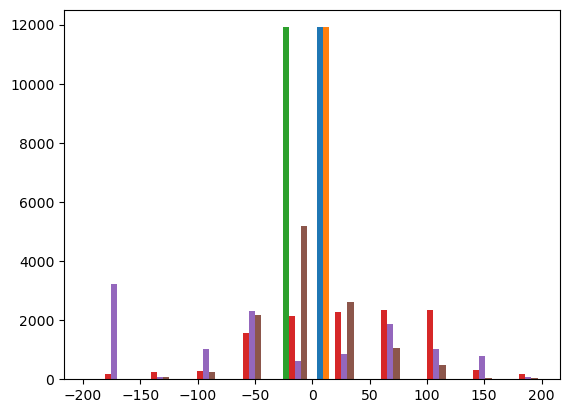

In [100]:
plt.hist(X); plt.show()

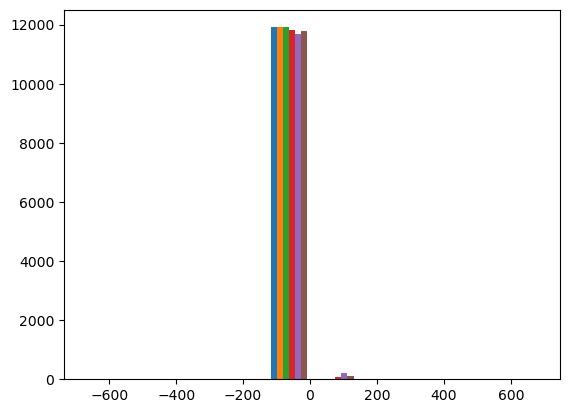

In [101]:
plt.hist(normalize(X)); plt.show()

In [104]:
np.min(X), np.max(X)

(-200.91403309059064, 200.5576480606978)

In [103]:
np.min(normalize(X)), np.max(normalize(X))

(-681.2463167364829, 693.5921566746431)

In [111]:
X_sparse = normalize(sp.csr_matrix(X, dtype=np.float32))
X_sparse

<11908x6 sparse matrix of type '<class 'numpy.float32'>'
	with 71448 stored elements in Compressed Sparse Row format>

In [109]:
np.max(normalize(sp.csr_matrix(X, dtype=np.float32)))

693.64124

In [110]:
np.min(normalize(sp.csr_matrix(X, dtype=np.float32)))

-681.2129

In [112]:
X_sparse.sum()

11908.0

In [113]:
X_sparse.sum(1)

matrix([[1.0000004 ],
        [1.        ],
        [0.99999964],
        ...,
        [0.99999964],
        [0.9999999 ],
        [1.        ]], dtype=float32)

In [127]:
X_sparse.todense(), X

(matrix([[-4.3901835e-02, -3.4939584e-01,  1.7127459e-01,  9.6841192e+00,
          -9.7691584e+00,  1.3070626e+00],
         [-1.4072767e-03, -1.1390159e-02,  5.5412273e-03,  1.1128095e-01,
           4.2758077e-01,  4.6839449e-01],
         [-4.4621816e-03, -3.5935894e-02,  1.7390095e-02,  1.8685755e+00,
           1.0491502e+00, -1.8947178e+00],
         ...,
         [-3.9860206e-03, -3.0176705e-02,  1.0917769e-02,  1.0075905e+00,
           1.0816621e+00, -1.0660077e+00],
         [ 7.4276784e-03,  5.6659542e-02, -2.0431308e-02, -1.6592951e+00,
           3.6742079e+00, -1.0585688e+00],
         [-9.3500747e-04, -7.3513971e-03,  2.5992417e-03,  1.0061620e+00,
          -1.8645585e-02,  1.8170690e-02]], dtype=float32),
 array([[ 1.62221557e-01,  1.29105168e+00, -6.32876273e-01,
         -3.57837637e+01,  3.60979903e+01, -4.82972347e+00],
        [ 1.61543278e-01,  1.30749235e+00, -6.36085279e-01,
         -1.27740964e+01, -4.90826007e+01, -5.37676607e+01],
        [ 1.62209479e-01,

In [122]:
np.shape(X_sparse.sum(1)), np.shape(X)

((11908, 1), (11908, 6))

In [120]:
X[0,:], X[0,:].sum()

(array([  0.16222156,   1.29105168,  -0.63287627, -35.78376369,
         36.09799034,  -4.82972347]),
 -3.6950998538670827)

In [129]:
X_sparse.todense()[0,:].sum()

1.0000005

In [133]:
sp.csr_matrix(torch.tensor([0,1,2,4]), dtype=np.float32).todense()

matrix([[0., 1., 2., 4.]], dtype=float32)

In [136]:
X[0,0], X[0,0].astype(np.float32)

(0.1622215568099475, 0.16222155)